# German Credit dataset

## Contents

_in this notebook:_

1. Frame the problem
2. Get the data
3. Explore and visualize the data
    - EDA _(to gain the general overview of the data)_
    - Hypothesis tests _(some hypotheses and statistical tests on them)_
    - Correlation analysis _(looking for correlation with the target variable)_
    - Outlier analysis
    - Missing values analysis
    - Feature transformation analysis _(are there any features that would need to be transformed?)_
    - Feature engineering _(interactions, ratios, other aggregations, decompositions/extractions e.g. on dates, etc)_


<br>

_in the next notebook:_

4. Build a simple baseline model
5. Prepare the data to better expose the underlying patterns to machine learning algorithm (incl feature engineering)
6. Explore many modesl; Select a model and train it
7. Fine-tune the model
8. Present your solution
9. Deploy, monitor and maintain your system


<br>

## 1. Frame the problem

- Explore the data extensively to gain insights and generate ideas _(in this notebook)_
- Build a classifier to predict a "bad" loan / account _(in the next notebook)_

<br><br>

### Imports:

In [1]:
# Imports from the Python Standard Library
import warnings
import re

from collections import OrderedDict
from itertools import permutations
from math import ceil, sqrt

In [2]:
# Imports of third-party libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter
from scipy import stats
from scipy.stats import chi2_contingency, kruskal, contingency, norm
import statsmodels.api as sm 
from statsmodels.formula.api import ols 


In [3]:
# Custom made utilities
from src.helper_utilities import load_data
from src.plotting_utilities import (plot_stacked_bar, 
                                    make_stacked_barcharts, 
                                    make_barcharts)
from src.reporting_utilities import print_hypothesis_test_report

In [4]:
# Settings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

## 2. Get the data

**Note:**
_In this dataset from the 1990s, there is no distinction between sex and gender, and all customers are categorized as either male or female. My analysis uses these binary categories based on the specifics of the data available._

In [5]:
# the original data
df = pd.read_csv('data/german.data', delimiter=' ', header=None)
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2
999,A12,45,A34,A41,4576,A62,A71,3,A93,A101,...,A123,27,A143,A152,1,A173,1,A191,A201,1


In [6]:
# load the user friendly dataframe with column and category names for handy EDA
df = load_data(mode='analysis')
df.tail()

,tenure,amount,rate,residence,age,credits,maintenance,history,savings,employment,...,status,purpose,guarantor,installments,housing,telephone,foreign,sex,personal,label
995,12,1736,3,4,31,1,1,so far so good,"[0, 100)","[4, 7)",...,no account,furniture,none,none,ownership,none,True,female,female divorced/separated/married,0
996,30,3857,4,4,40,1,1,so far so good,"[0, 100)","[1, 4)",...,overdrawn,used car,none,none,ownership,yes,True,male,male divorced/separated,0
997,12,804,4,4,38,1,1,so far so good,"[0, 100)","[7, inf)",...,no account,television,none,none,ownership,none,True,male,male single,0
998,45,1845,4,4,23,1,1,so far so good,"[0, 100)","[1, 4)",...,overdrawn,television,none,none,without payment,yes,True,male,male single,1
999,45,4576,3,4,27,1,1,critical,"[100, 500)",unemployed,...,petty,used car,none,none,ownership,none,True,male,male single,0


# 3. Explore the Data

The target variable has two classes. The positive class is the "bad" accounts (that have led to defaults).

Explore the values in each feature:

In [74]:
# Number of unique values in each feature: numeric and categorical
pd.DataFrame({"no. of unique values": df.nunique(axis=0), 
              "unique values": df.apply(lambda column: str(list(column.unique()))[:100][1:-1].replace("'", ""), axis=0),
              "mode": df.mode(axis=0).iloc[:1, :].T.squeeze(),
              "data type": df.dtypes})

,no. of unique values,unique values,mode,data type
tenure,33,"6, 48, 12, 42, 24, 36, 30, 15, 9, 10, 7, 60, 1...",24.0,int64
amount,921,"1169, 5951, 2096, 7882, 4870, 9055, 2835, 6948...",1258,int64
rate,4,"4, 2, 3, 1",4.0,int64
residence,4,"4, 2, 3, 1",4.0,int64
age,53,"67, 22, 49, 45, 53, 35, 61, 28, 25, 24, 60, 32...",27.0,int64
credits,4,"2, 1, 3, 4",1.0,int64
maintenance,2,"1, 2",1.0,int64
history,5,"critical, so far so good, delay, no loans, dul...",so far so good,category
savings,5,"no savings, Interval(0, 100, closed=left), Int...","[0, 100)",category
employment,5,"Interval(7, inf, closed=left), Interval(1, 4, ...","[1, 4)",category


In [8]:
print(f'proportion of "bad" customers: {df.label.sum() / len(df)}')

proportion of "bad" customers: 0.3


## Exploratory Data Analysis

### Descriptive statistics

In [9]:
# Basic descriptive statistics for selected numerical features
df.describe().iloc[1:, :-3].round(1)

,tenure,amount,rate,residence,age
mean,20.9,3271.3,3.0,2.8,35.5
std,12.1,2822.7,1.1,1.1,11.4
min,4.0,250.0,1.0,1.0,19.0
25%,12.0,1365.5,2.0,2.0,27.0
50%,18.0,2319.5,3.0,3.0,33.0
75%,24.0,3972.2,4.0,4.0,42.0
max,72.0,18424.0,4.0,4.0,75.0


### Bar charts for categorical features

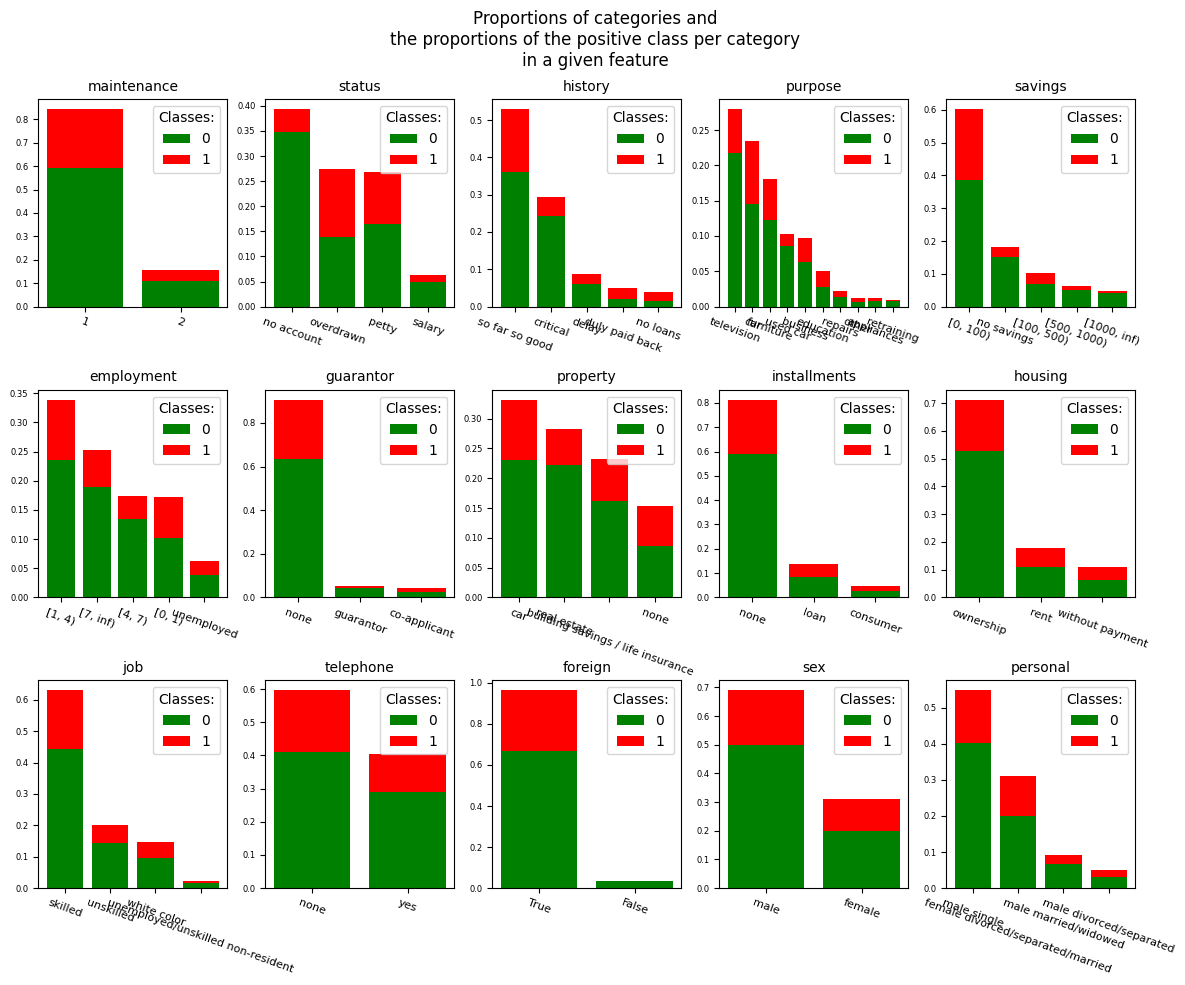

In [10]:
# Bar charts for categorical features
cols = ['maintenance', 'status', 'history', 'purpose', 'savings', 'employment', 
        'guarantor', 'property', 'installments', 'housing', 'job', 'telephone', 'foreign', 'sex', 'personal']

fig = make_stacked_barcharts(df, features=cols);

### A slightly different view on the categorical features:
The categories in a given feature are sorted by the proportion of "bad" credits in them. (The shadings of red in each bar indicate the proportion of the "bad" class in that category, i.e. the riskiest category is the first bar in each plot)

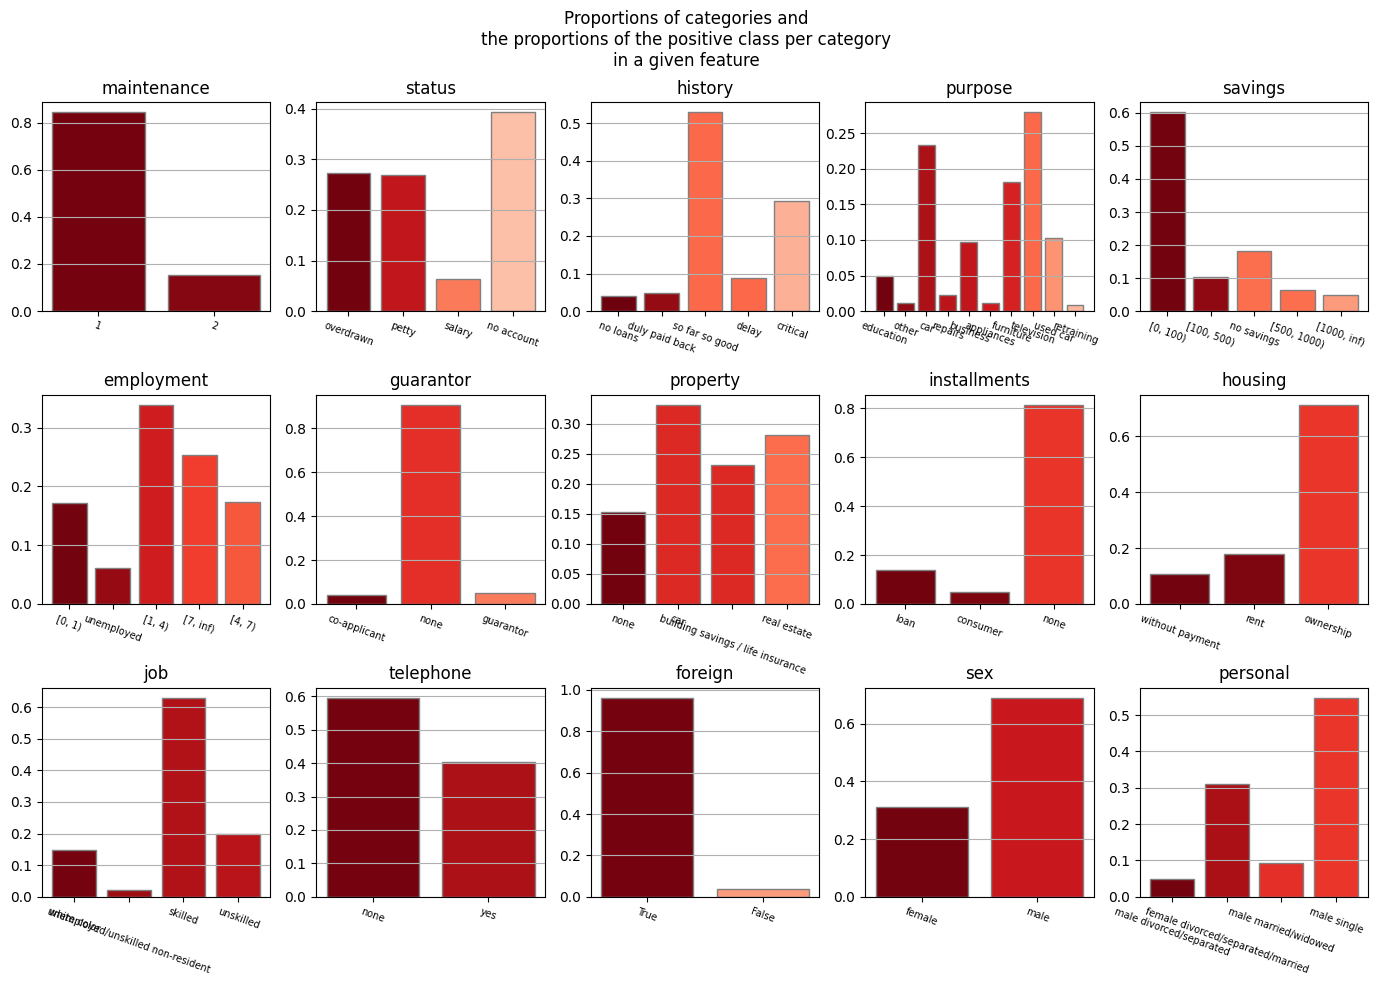

In [11]:
# Bar charts with the categories sorted by the proportion of "bad" credits in them
fig = make_barcharts(df, features=cols, square=False)

### Distribution of tenure

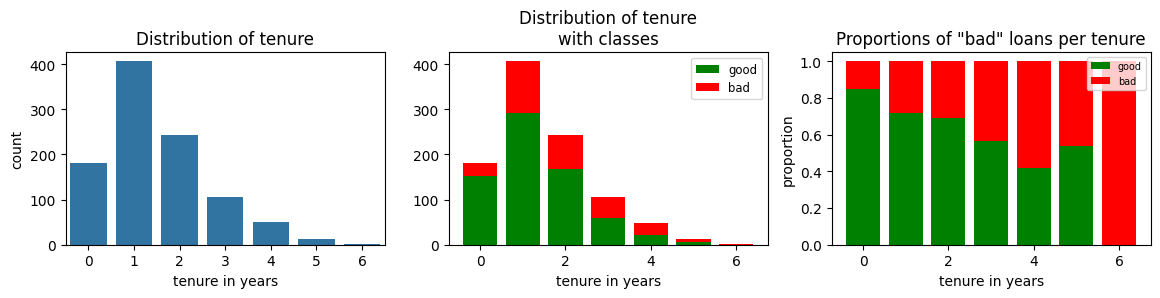

In [12]:
# Distribution of tenure in years
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(14, 2.5))

# plot1
sns.countplot(x=df['tenure'] // 12, ax=ax1)
ax1.set_xlabel("tenure in years")
ax1.set_ylabel("count")
ax1.set_title("Distribution of tenure");

# plot2
data = df[['tenure', 'label']].groupby(by=df['tenure']//12).agg({'tenure': 'count' ,'label': 'mean'}).assign(good=lambda df: 1 - df['label'])
xlabels = list(data.index)
good = data['good'].values
bad = data['label'].values
data["bad"] = data.pop('label')
data = data.rename(columns={'tenure': "counts"}).reset_index()
data[['good', 'bad']] = (data[['good', 'bad']].values * data[['counts']].values).astype(np.uint16)

ax2.bar(data['tenure'], height=data['good'], color='green', label="good")
ax2.bar(data['tenure'], height=data['bad'], bottom=data['good'], color='red', label="bad")
ax2.set_title("Distribution of tenure\nwith classes")
ax2.set_xlabel(ax1.get_xlabel())
ax2.legend(fontsize='small');

# plot3
ax3.bar(xlabels, height=good, color='green', label="good")
ax3.bar(xlabels, height=bad, bottom=good, color='red', label="bad")
ax3.set_title('Proportions of "bad" loans per tenure')
ax3.set_xlabel(ax1.get_xlabel())
ax3.set_ylabel("proportion")
ax3.legend(fontsize='x-small');


### How much in savings do the customers of the bank have?

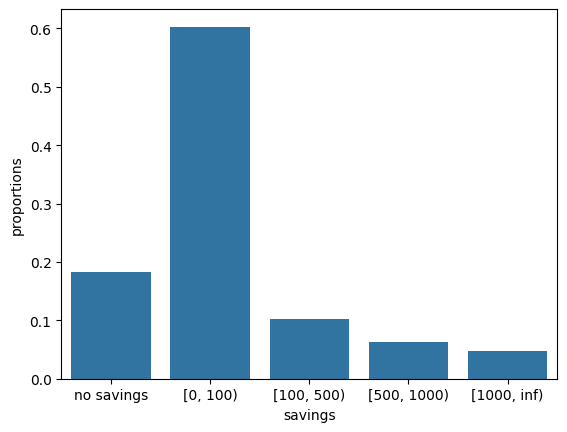

In [13]:
# Barchart
sr_counts = df['savings'].value_counts()
sr_props  = (sr_counts / sr_counts.sum()).sort_index()
sns.barplot(x=sr_props.index, y=sr_props.values).set_ylabel("proportions");

### Does the tenure affect how much in savings the clients have?

The following heatmap shows us that there is no such correlation (the longer a client stays with the bank the higher the savings)

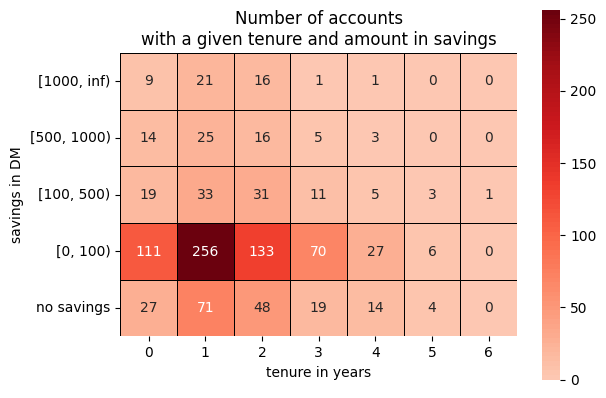

In [14]:
# Heatmap
frequancy_table = pd.crosstab(index=df['tenure'], columns=df['savings'])

ax = sns.heatmap(frequancy_table.groupby(frequancy_table.index // 12).sum().T.sort_index(ascending=False), 
            cmap=sns.color_palette(palette='Reds', n_colors=100)[20:], 
            linewidths=0.5, linecolor='black', square=True, annot=True, fmt='.0f', vmin=0)
ax.set_xlabel("tenure in years")
ax.set_ylabel("savings in DM")
ax.set_title("Number of accounts\nwith a given tenure and amount in savings");

### What is the average loan per category?

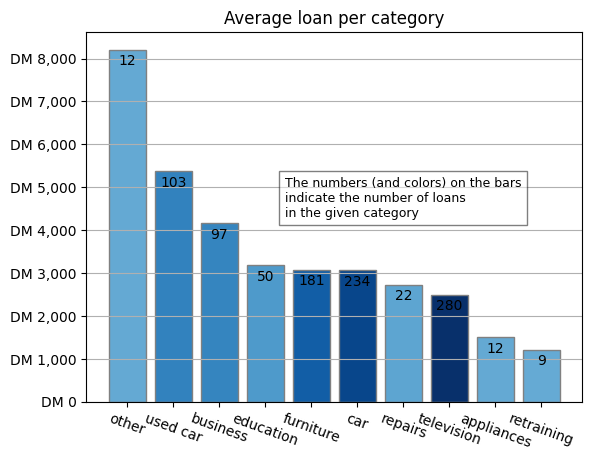

In [15]:
# Average loan per category (for example average loan amount borrowed to buy a car, etc)

data = df[['purpose', 'amount']].groupby('purpose').mean().sort_values(by='amount', ascending=False)

idx = counts = df['purpose'].value_counts().reindex(index=data.index).values
n_colors = 3
colors = np.array(sns.color_palette('Blues', n_colors=counts.max()*2+2))[-counts.max()-1:][idx]

plt.bar(data.index, height=data['amount'], color=colors, edgecolor='grey')

# Annotate bars with their heights
for i, (h, k) in enumerate(zip(data['amount'], counts)):
    plt.text(i, h-350, str(k), ha='center')

# Text box
plt.text(.4, .5, 'The numbers (and colors) on the bars\nindicate the number of loans\nin the given category', 
        fontsize=9, 
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.5))

plt.xticks(rotation=-20)
plt.title("Average loan per category")

formatter = StrMethodFormatter("DM {x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.grid(True, which='major', axis='y');

### More details about the loan categories

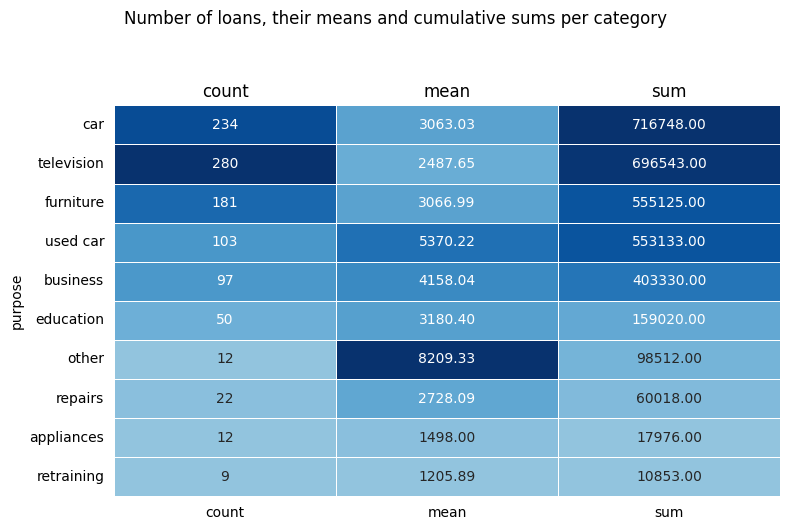

In [16]:
# Heatmap table
cols = ['purpose', 'amount']
data = df[cols].groupby('purpose').agg(['count', 'mean', 'sum'])
data.columns = data.columns.droplevel(level=0)
data = data.sort_values('sum', ascending=False)
data.iloc[:, 1:] = data.iloc[:, 1:].astype(float).round(2)

fig, axes = plt.subplots(1, data.shape[1], figsize=(8, 5), sharey=True)

# Plot each column with its colormap
cmap = sns.color_palette('Blues', n_colors=100)[-60:]

for j, (col, ax) in enumerate(zip(data.columns, axes)):
    sns.heatmap(data[[col]], cmap=cmap, ax=ax, cbar=False, 
                annot=True, linewidth=0.5, fmt='.2f' if j else ',.0f')
    ax.set_title(col)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xlabel('')
    if j: ax.set_ylabel('')

plt.suptitle('Number of loans, their means and cumulative sums per category', y=1.05)
plt.tight_layout()
plt.subplots_adjust(wspace=0)

##### Ideas for future analysis:

- Who is a typical person wanting to buy a (new) car: age, job, income-bracket, house-owner, male/female
- What distinguishes a person with a bad credit?: multiple hypothesis tests per feature per category?
- What's typical of the senior clients of the bank? (over 65 years old)

<br><br>

## Hypothesis Tests

**Note:**
_In this dataset from the 1990s, there is no distinction between sex and gender, and all customers are categorized as either male or female. My analysis uses these binary categories based on the specifics of the data available._

### Is the proportion of "bad" loans in females greater than in male customers?

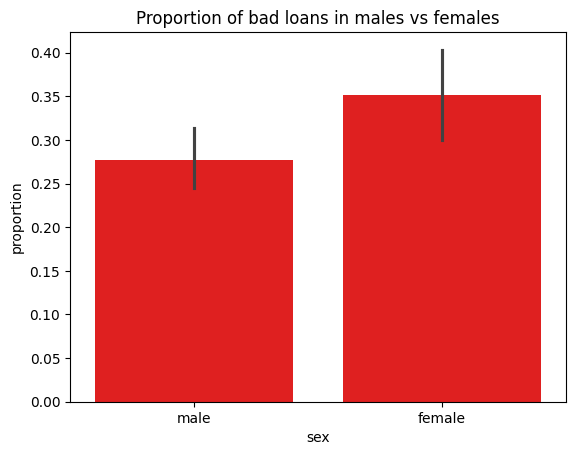

In [17]:
ax = sns.barplot(df, x='sex', y='label', color='red')
ax.set_ylabel("proportion")
ax.set_title("Proportion of bad loans in males vs females");

The results of the z-test below show that the proportion of bad loans among female customers is significantly higher

In [18]:

# Hypothesis Test for the difference in proportions

"""
Test for the proportion of "bad" loans in male vs female customers

Q: "Is the proportion of bad loans in males less than in females?"

success = the "bad" class
statistic: z
alpha = 0.05
alternative hypothesis: the first proportion (males) is less
"""

# Prepare the data
data = df[['sex', 'label']].groupby('sex').agg(['size', 'mean'])
data.columns = data.columns.droplevel(level=0)
data.columns = ["count", "proportion"]
data = data.reindex(index=['male', 'female'])

# Test the requirements
n1, p1, n2, p2 = data.values.ravel()
all([n1 * p1 >= 10, n1 * (1 - p1) >= 10, n2 * p2 >= 10, n2 * (1 - p2) >= 10])   # all True

# Combined proportion
p = (n1*p1 + n2*p2) / (n1+n2)

# Standard Error
se = sqrt(p * (1 - p) * (1/n1 + 1/n2))

# Compute the Test Statistic
z = (p1 - p2) / se

# Compute the p-value
pvalue = norm.cdf(z)

# Report
print_hypothesis_test_report(pvalue, "there is no difference between the proportions of the two populations",
                                     "the proportion of bad loans in females is greater than in males")


Hypothesis Test Report:
α = 0.05
p-value = 0.00849
H₀: there is no difference between the proportions of the two populations
reject H₀?: yes
conclusion: the proportion of bad loans in females is greater than in males




### Are the loans among male customers in general higher than among female customers?

amount                        
        count    mean  median     std
sex                                  
female    310  2878.0  1959.0  2603.0
male      690  3448.0  2444.0  2900.0

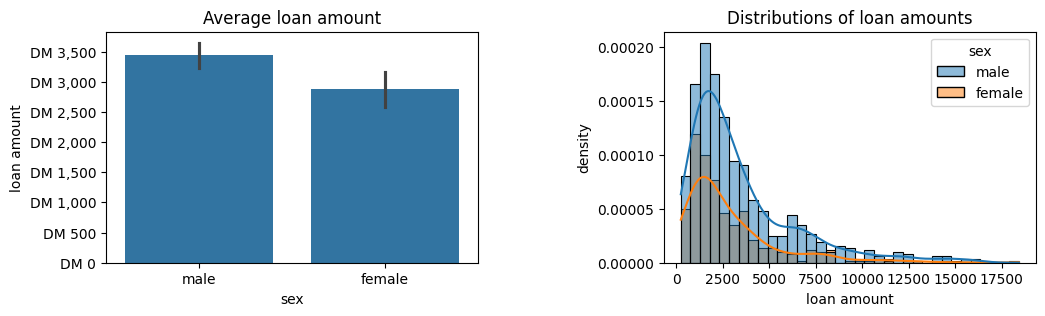

In [19]:
# Aggregation table and plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))

sns.barplot(df, x='sex', y='amount', ax=ax1)
ax1.set_ylabel("loan amount")
ax1.set_title("Average loan amount")
ax1.yaxis.set_major_formatter(StrMethodFormatter("DM {x:,.0f}"));

sns.histplot(df, x='amount', hue='sex', kde=True, stat='density', ax=ax2)
ax2.set_xlabel("loan amount")
ax2.set_ylabel("density")
ax2.set_title("Distributions of loan amounts")
fig.subplots_adjust(wspace=0.5, hspace=0.5)

df[['sex', 'amount']].groupby('sex').agg(['count', 'mean', 'median', 'std']).round()

We perform the Mann-Whitney U (and not the t-test or Welch's t-test) because the assumptions about normality and equal variances are violated.

The results of the Mann-Whitney U test indicate that the loan amounts among male customers tend to be higher.

In [20]:
sample1 = df.loc[df['sex']=='female', 'amount']
sample2 = df.loc[df['sex']=='male', 'amount']

alpha = 0.05
statistic, pvalue = stats.mannwhitneyu(sample1, sample2)

print_hypothesis_test_report(pvalue, "the distributions of both populations are equal",
                                     "the loans among male customers tend to be higher")

Hypothesis Test Report:
α = 0.05
p-value = 0.00025
H₀: the distributions of both populations are equal
reject H₀?: yes
conclusion: the loans among male customers tend to be higher




### Do the amounts of "bad" loans tend to be higher?

amount                        
       count    mean  median     std
label                               
0        700  2985.0  2244.0  2401.0
1        300  3938.0  2574.0  3536.0

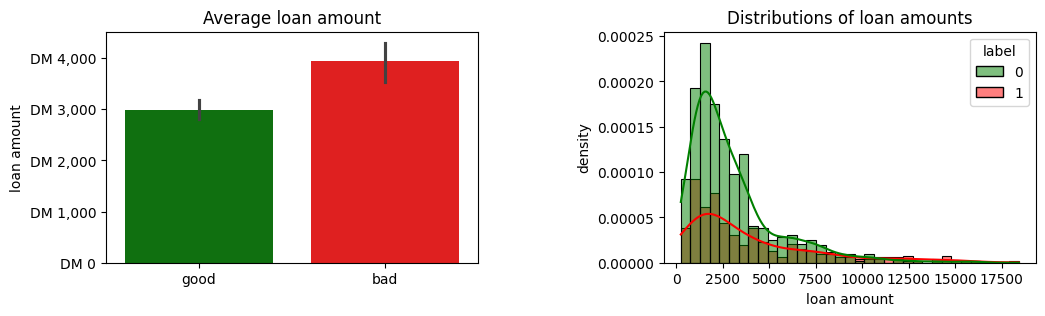

In [21]:
# Aggregation table and plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,3))

sns.barplot(df, x='label', y='amount', ax=ax1, palette=['green', 'red'])
ax1.set_xlabel(None)
ax1.set_ylabel("loan amount")
ax1.set_title("Average loan amount")
ax1.yaxis.set_major_formatter(StrMethodFormatter("DM {x:,.0f}"))
ax1.set_xticklabels(["good", "bad"])

sns.histplot(df, x='amount', hue='label', kde=True, stat='density', palette=['green', 'red'], ax=ax2)
ax2.set_xlabel("loan amount")
ax2.set_ylabel("density")
ax2.set_title("Distributions of loan amounts")
fig.subplots_adjust(wspace=0.5, hspace=0.5)

df[['label', 'amount']].groupby('label').agg(['count', 'mean', 'median', 'std']).round()


The results of the Mann-Whitney U test indicate that the amounts of "bad" loans tend to be higher.

In [22]:
sample1 = df.loc[df['label']==0, 'amount']
sample2 = df.loc[df['label']==1, 'amount']

alpha = 0.05
statistic, pvalue = stats.mannwhitneyu(sample1, sample2)

print_hypothesis_test_report(pvalue, "the distributions of both populations are equal",
                                     '"bad" loans tend to be higher')

Hypothesis Test Report:
α = 0.05
p-value = 0.00592
H₀: the distributions of both populations are equal
reject H₀?: yes
conclusion: "bad" loans tend to be higher




### Are the loan amounts the same among the different job types?

,count,mean,median
job,,,
white color,148,5435.0,4459.0
skilled,630,3071.0,2324.0
unemployed/unskilled non-resident,22,2745.0,1416.0
unskilled,200,2359.0,1622.0


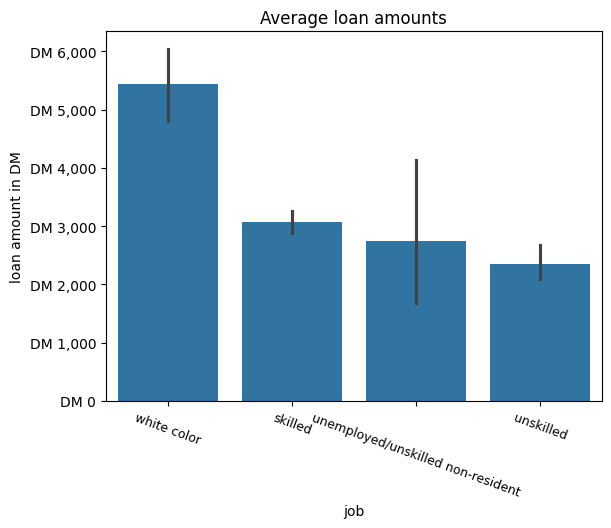

In [23]:
# Aggregation table and bar chart
data = df[['job', 'amount']].groupby('job').agg(['count', 'mean', 'median']).droplevel(level=0, axis=1).round().sort_values('mean', ascending=False)

ax = sns.barplot(df, x='job', y='amount', order=data.index)
ax.set_title("Average loan amounts")
ax.set_ylabel("loan amount in DM")
ax.set_xticks(list(range(4)), data.index, rotation=-20, fontsize=9)
ax.yaxis.set_major_formatter(StrMethodFormatter("DM {x:,.0f}"))

data

We'll exclude the 'white color' category from the test because this category is definitely higher than the rest.

Kruskal-Wallis test results show that the medians of the loan amount among different job types are not the same:

In [24]:
# get the 3 samples
samples = df[['job', 'amount']].groupby('job').agg(list).values.ravel()[:-1]

alpha = 0.05
_, pvalue = kruskal(*samples)

print_hypothesis_test_report(pvalue, "the populations from which the samples were drawn have equal medians",
                                     "the loan amounts among different job types do differ")

Hypothesis Test Report:
α = 0.05
p-value = 0.0
H₀: the populations from which the samples were drawn have equal medians
reject H₀?: yes
conclusion: the loan amounts among different job types do differ




### Are variables `age`and `amount` correlated?

Visaul inspection shows that the slope of the regression line is close to zero and probably not statistically significant:

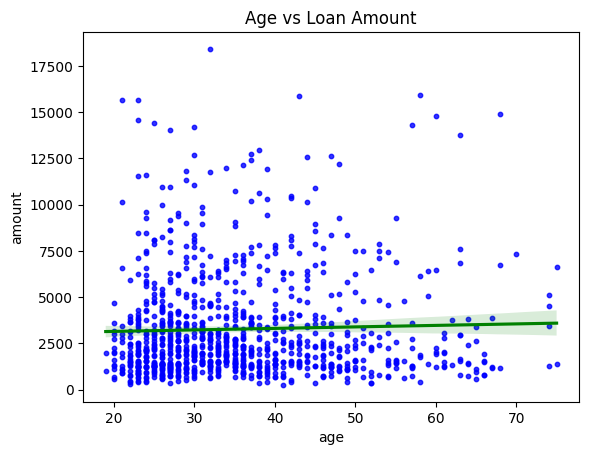

In [25]:
ax = sns.regplot(df, x='age', y='amount', scatter_kws={'color': 'blue', 's': 10}, line_kws={'color': 'green'})
ax.set_title("Age vs Loan Amount");

Spearman correlation test results confirms that there is no significant correlation:

In [26]:
alpha = 0.05
spearman_correlation_coefficient, pvalue = stats.spearmanr(df['age'], df['amount'])

print("Spearman correlation coefficient =", round(spearman_correlation_coefficient, 2), end="\n\n")

print_hypothesis_test_report(pvalue, "there is no monotonic relationship between the two variables",
                                     "'age' and 'amount' have no (monotonic) correlation")

Spearman correlation coefficient = 0.03

Hypothesis Test Report:
α = 0.05
p-value = 0.40612
H₀: there is no monotonic relationship between the two variables
reject H₀?: no
conclusion: 'age' and 'amount' have no (monotonic) correlation




### Do factors "credit history" and "customer sex" play a role in the loan amount: 
we will conduct a two-way ANOVA test

,history,sex,size,mean
0,no loans,female,12,5483.0
2,duly paid back,female,17,3730.0
4,so far so good,female,186,2656.0
6,delay,female,16,3244.0
8,critical,female,79,2747.0
1,no loans,male,28,5230.0
3,duly paid back,male,32,3140.0
5,so far so good,male,344,3249.0
7,delay,male,72,4538.0
9,critical,male,214,3214.0


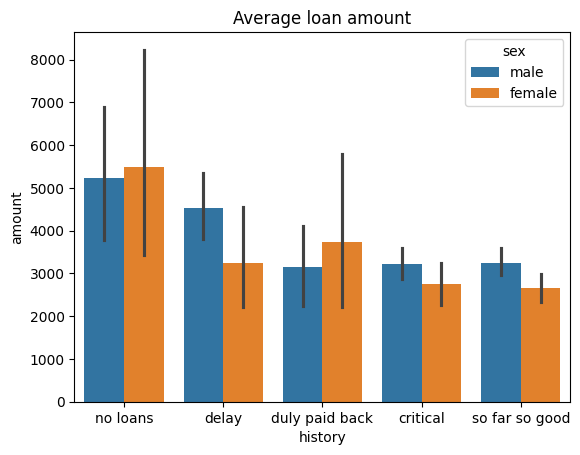

In [27]:
# Aggregation table and bar chart
order = df[['history', 'amount']].groupby('history').mean().sort_values('amount', ascending=False).index
ax = sns.barplot(df, x='history', y='amount', hue='sex', order=order)
ax.set_title("Average loan amount")

(
        pd.concat([df['history'], df['sex'], df['amount']], axis=1)
                .groupby(['history', 'sex']).agg(['size', 'mean'])
                .droplevel(level=0, axis=1)
                .reset_index()
                .sort_values('sex').round(0)
)

To comply with the assumptions of ANOVA we will transform `amount` with the natural logarithm to make the distribution look more or less normally distributed:

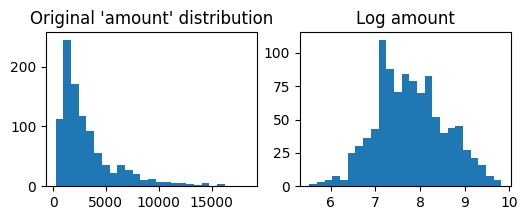

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,2))
n_bins = 25
log_amount = np.log(df['amount'])
df['amount'].hist(bins=n_bins, grid=False, ax=ax1)
ax1.set_title("Original 'amount' distribution")
pd.Series(log_amount).hist(bins=n_bins,  grid=False, ax=ax2)
ax2.set_title("Log amount");

Prepare the data for the two-way ANOVA:

In [29]:
data = pd.concat([df[['history', 'sex']], log_amount], axis=1)
data.columns = ["factorA", "factorB", "values"]
data.tail()

,factorA,factorB,values
995,so far so good,female,7.459339
996,so far so good,male,8.257645
997,so far so good,male,6.689599
998,so far so good,male,7.520235
999,critical,male,8.428581


The results of the two-factor ANOVA test indicate that both factors 'credit history' and 'customer sex' influence the loan mean. 
However there is no interaction between these factors:

In [30]:
alpha = 0.05
model = ols('values ~ factorA + factorB + factorA:factorB', data=data).fit() 
result = sm.stats.anova_lm(model, typ=2) 
print(result) 

pvalues = result.values[:-1, -1]
print("Reject H0?:", pvalues < alpha)

                     sum_sq     df          F    PR(>F)
factorA           17.630207    4.0   7.591645  0.000005
factorB            6.588141    1.0  11.347531  0.000785
factorA:factorB    1.693641    4.0   0.729289  0.572012
Residual         574.773457  990.0        NaN       NaN
Reject H0?: [ True  True False]


<br><br>

## Explore the Correlation with the Target

### Class separation
The following histograms show that no individual numerical feature separates the two classes:

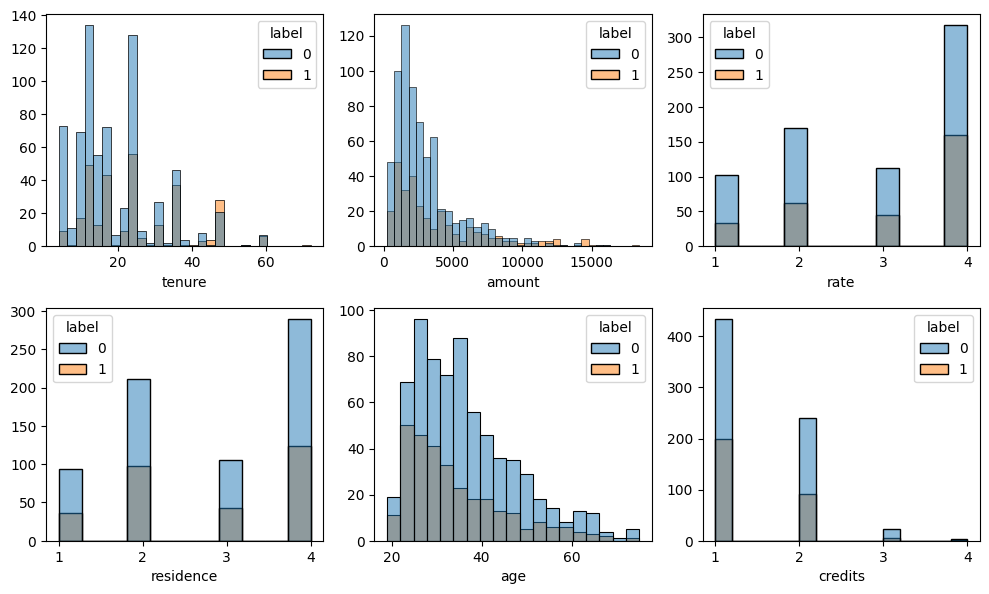

In [31]:
# Histograms of numerical features
df_num = df.select_dtypes(np.number).assign(label=df['label'])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    if i >= df_num.shape[1]-2:
        plt.delaxes(ax)
        continue
    sns.histplot(df_num, x=df_num.columns[i], hue='label', ax=ax)
    ax.set_ylabel(None)
plt.tight_layout()


### Pearson's correlation coefficients for the numerical features

Pearson's correlation coefficients below show that `tenure` and `amount` have a weak correlation with the target:

_(we are allowed to use Person's correlation on these numerical features because the target variable is binary)_

In [32]:
df_num.corr().iloc[-1].sort_values(key=abs, ascending=False)[1:]

tenure         0.214927
amount         0.154739
age           -0.091127
rate           0.072404
credits       -0.045732
maintenance   -0.003015
residence      0.002967
Name: label, dtype: float64

The following boxplots visually confirm the above Person's correlation coefficients:

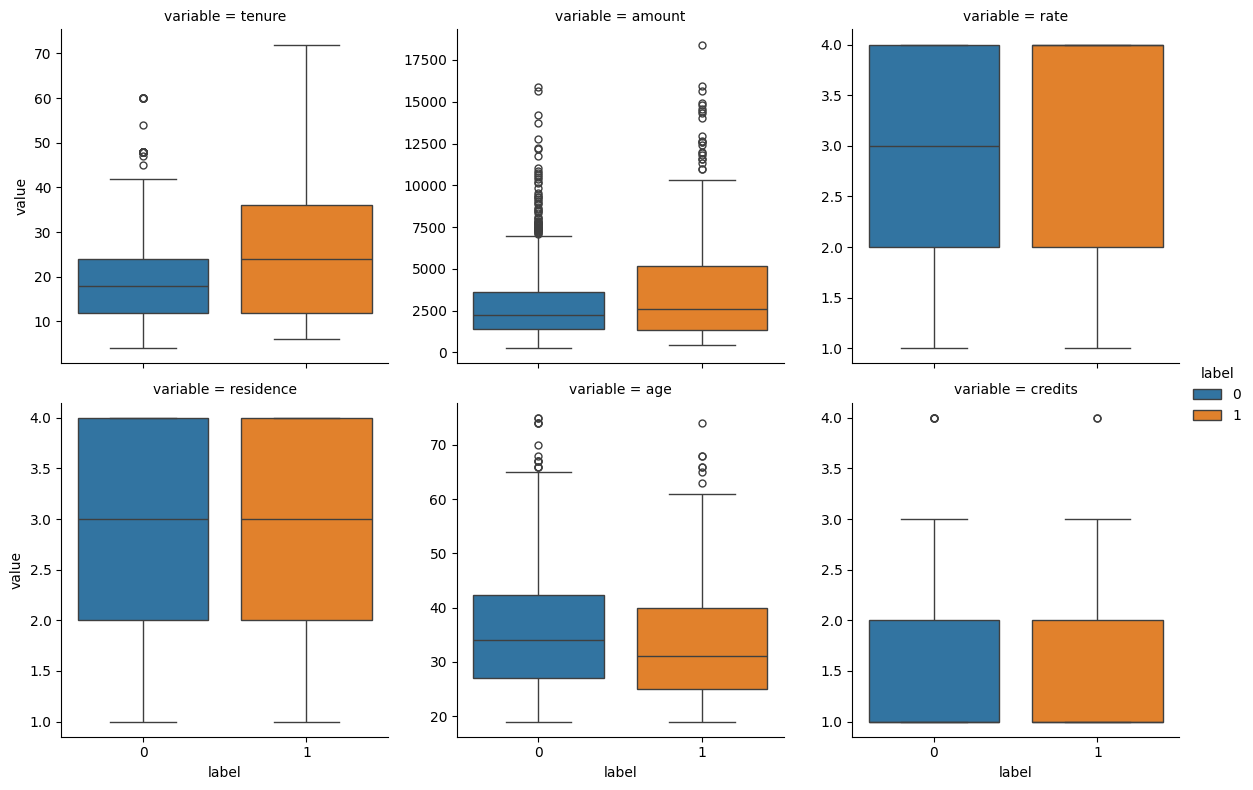

In [33]:
sns.catplot(df_num.drop('maintenance', axis=1).melt(id_vars='label'), 
            x='label', y="value", col="variable", hue='label', kind="box",
            sharey=False, col_wrap=3, height=4);

### Kruskal-Wallis, Chi-Squared and CramersV tests for the categorical features

Perform Kruskal-Wallis test on these features:
- duration         
- amount          
- rate           
- residence        
- age              
- credits           

... and Chi-Squared test for independence + CramersV test on the rest of the features:

In [34]:
# Kruskal-Wallis tests

alpha = 0.01  # also try 0.05
cols = ['tenure', 'amount', 'rate', 'residence', 'age', 'credits']
collector = []

for col in cols:
    res = kruskal(*df[col].groupby(df['label']).agg(list).values)
    collector.append([col, res.statistic, res.pvalue, (f"not" if res.pvalue < alpha else "") + " independent"])

pd.DataFrame(collector, columns=["feature", "H-statistic", "p-value", "hypothesis test result"]).round(2)

,feature,H-statistic,p-value,hypothesis test result
0,tenure,42.26,0.00,not independent
1,amount,7.58,0.01,not independent
2,rate,5.42,0.02,independent
3,residence,0.01,0.94,independent
4,age,12.57,0.00,not independent
5,credits,2.24,0.13,independent


In [35]:
# Chi-Squared and CramersV tests
alpha = 0.01
cols = ['maintenance', 'status', 'history', 'purpose', 'savings', 'employment', 
        'guarantor', 'property', 'installments', 'housing', 'job', 'telephone', 'foreign', 'sex', 'personal']
collector = []

for col in cols:
    res = chi2_contingency(pd.crosstab(df[col], df['label']))
    V = contingency.association(pd.crosstab(df[col], df['label']), method='cramer')
    collector.append([
        col, res.statistic, res.pvalue, (f"not" if res.pvalue < alpha else "") + " independent",
        V, ["none", "weak", "moderate", "strong", "very strong"][np.greater(V, [.05, .1, .15, .25]).sum()]
                      ])

pd.DataFrame(collector, columns=["feature", "statistic", "p-value", f"{chr(0x03A7) + chr(0x00b2) } hyp. test result", "V", "CramersV correlation"]).round(2)


,feature,statistic,p-value,Χ² hyp. test result,V,CramersV correlation
0,maintenance,0.00,1.00,independent,0.00,none
1,status,123.72,0.00,not independent,0.35,very strong
2,history,61.69,0.00,not independent,0.25,strong
3,purpose,33.36,0.00,not independent,0.18,strong
4,savings,36.10,0.00,not independent,0.19,strong
5,employment,18.37,0.00,not independent,0.14,moderate
6,guarantor,6.65,0.04,independent,0.08,weak
7,property,23.72,0.00,not independent,0.15,strong
8,installments,12.84,0.00,not independent,0.11,moderate
9,housing,18.20,0.00,not independent,0.13,moderate


So, the best categorical features are:
- status
- history
- savings
- purpose
- property

The best numerical features are:
- tenure
- age
- amount

<br>

## Outlier Analysis

Visual inspection of box-plots indicate that the outliers are plausible values, hence we will not remove or cap these instances.

Other analytical methods (like Z-score or Mahalanobis distance) are not applicable here because our numerical variables are not normally distributed.

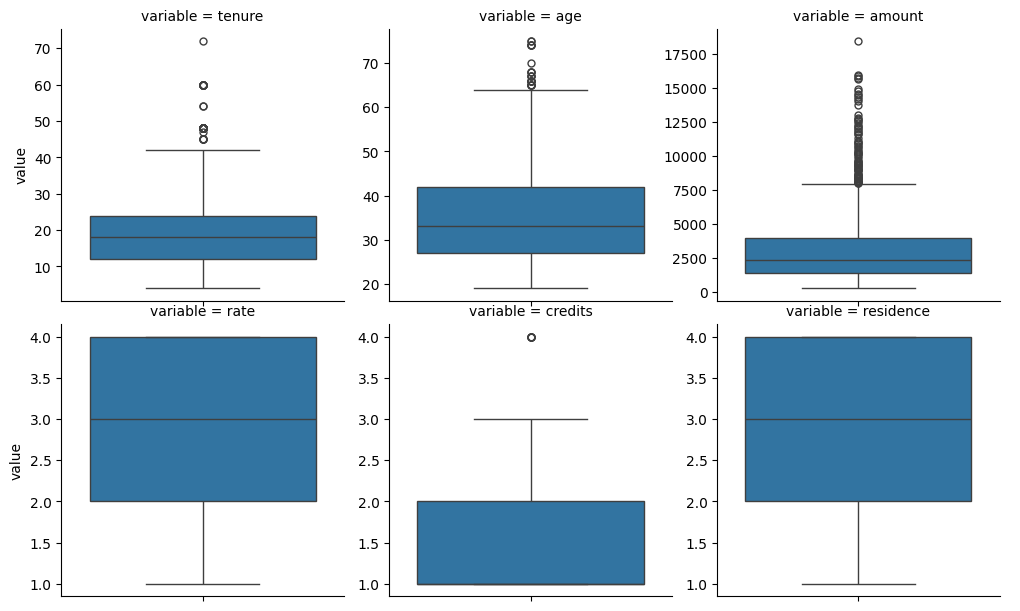

In [36]:
# numerical columns (in the order of correlation with the target)
num_cols = ['tenure', 'age', 'amount', 'rate', 'credits', 'residence']

grid = sns.catplot(data=df[num_cols].melt(), kind='box', col='variable', y='value', sharey=False, col_wrap=3)
grid.fig.set_size_inches(10, 6);


Out of curiosity, let's have a look at the record with the `amount` over DM17,500

In [37]:
df[df['amount']>17500]

,tenure,amount,rate,residence,age,credits,maintenance,history,savings,employment,...,status,purpose,guarantor,installments,housing,telephone,foreign,sex,personal,label
915,48,18424,1,2,32,1,1,no loans,"[0, 100)","[1, 4)",...,petty,other,none,loan,ownership,yes,False,female,female divorced/separated/married,1


Let's make pair scatter plots, to see if we have any multivariate outliers.

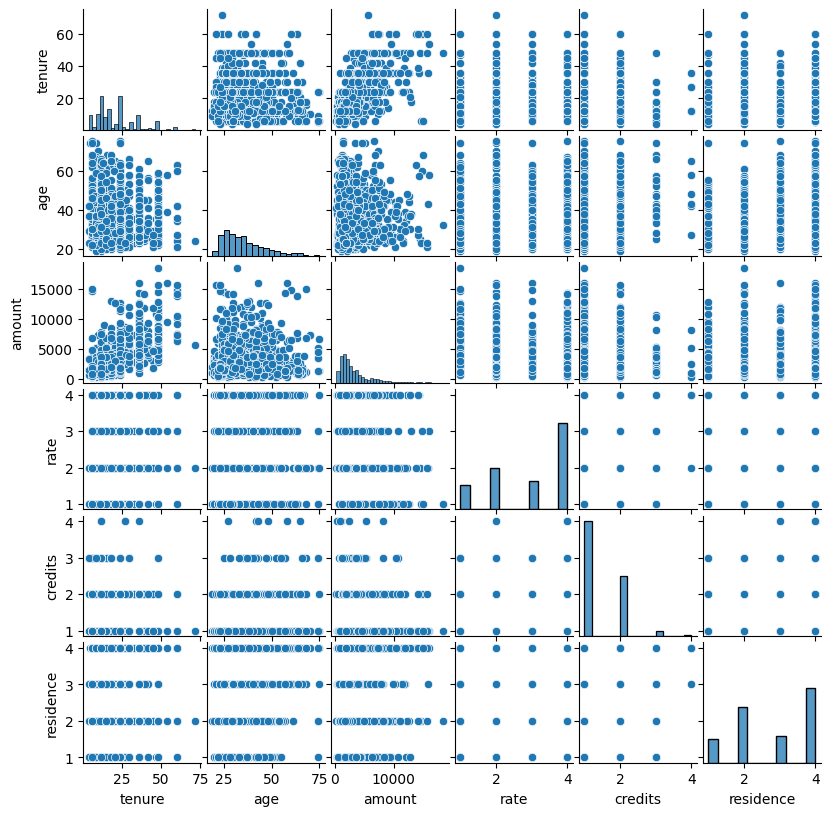

In [38]:
# No multivariate outliers are visible here
grid = sns.pairplot(df[num_cols])
grid.fig.set_size_inches(8, 8);

## Missing Values

There are no missing values

## Feature engineering 

Q: Are there any sensible interactions, ratios or aggregations?

A: There are no obvious ratios that could be made from these features: 'tenure', 'age', 'amount' and which would make sense. Just for fun, let's permute these three features and see which ratio correlates best with the target.

In [39]:
# Make ratios of features
pairs = [list(t) for t in permutations(['tenure', 'age', 'amount'], r=2)]
correlations = pd.Series({tuple(cols): np.corrcoef(df[cols].apply(lambda row: row[0]/row[1], axis=1), df['label'])[0,1] for cols in pairs}).reset_index()
correlations.columns = ["numerator", "denominator", "correlation"]
correlations.sort_values('correlation', key=abs, ascending=False).reset_index(drop=True).reset_index(drop=True)

,numerator,denominator,correlation
0,tenure,age,0.232437
1,age,tenure,-0.201914
2,amount,age,0.166210
3,age,amount,-0.106048
4,tenure,amount,0.089998
5,amount,tenure,0.018592


`tenure/age` has a weak correlation with the target. Since it beats all the numerical features, we'll include this new engineered feature into our model.

## Feature transformation

Q: Are there any features that would need to be transformed?

A: 'tenure', 'age', 'amount' and 'ratio' might need to be transformed with the natural logarithm (however not if used with a decision tree based algorithm)

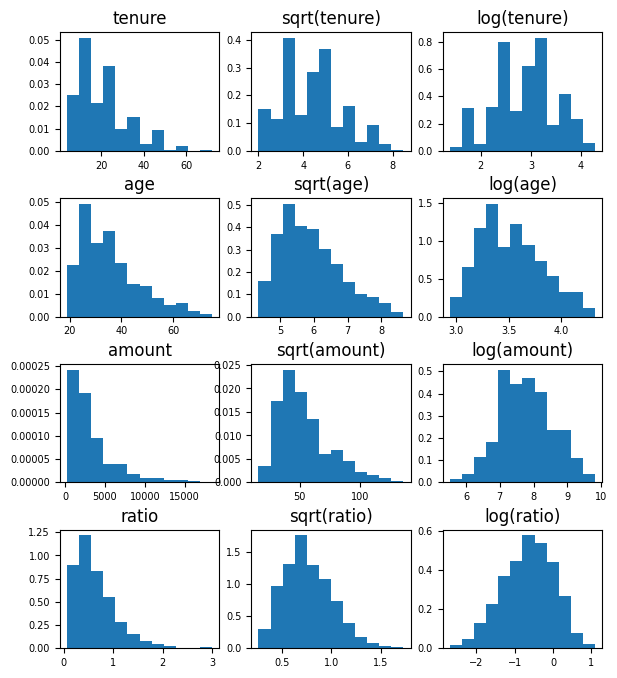

In [40]:
data = df[['tenure', 'age', 'amount']].assign(ratio=lambda df: df['tenure']/df['age'])

fig, axes = plt.subplots(4, 3, figsize=(7,8))

for col, axs in zip(data.columns, axes):
    for func, func_name, ax in zip([lambda x:x, np.sqrt, np.log], [None, "sqrt", "log"], axs):
        ax.hist(func(data[col]), bins=12, density=True)
        ax.set_title(f"{func_name}({col})" if func_name else col)
        ax.tick_params(axis='x', labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
plt.subplots_adjust(hspace=0.4)
